In [2]:
from __future__ import print_function
import os
import argparse
import pickle
import torch
from torchvision import datasets, transforms

from model import SoftDecisionTree

from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10

print("tensorflow version: ", tf.__version__)
print("keras version: ", keras.__version__)
import sklearn

print("sklearn version: ", sklearn.__version__)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.utils import check_array, check_random_state
from sklearn.utils import shuffle as util_shuffle
import numpy as np

print("numpy version: ", np.__version__)
import matplotlib

print("matplotlib version: ", matplotlib.__version__)
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import cv2

print("cv2 version: ", cv2.__version__)
import math
from statistics import mean, stdev
import os
import sys
import pandas as pd

print("pandas version: ", pd.__version__)
import time
from tqdm import tqdm

from scipy import spatial

from collections import Counter

from joblib import Parallel, delayed
import multiprocessing

import math
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import seaborn as sn
from sklearn.model_selection import train_test_split
import random
import pickle

2023-07-04 21:09:28.862647: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 21:09:29.472826: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensorflow version:  2.12.0
keras version:  2.12.0
sklearn version:  1.2.2
numpy version:  1.23.3
matplotlib version:  3.7.1
cv2 version:  4.7.0
pandas version:  2.0.0


# CIFAR 10

In [8]:
# train
datadir = "/media/hongyu/SSD/SSDUBUNTU/WUSL/Pixelhop-Pytorch/data/cifar10_dataaug_200K.pkl"
# datadir = './data/dataaug_200K.pkl'
x_train, y_train_200K = pickle.load(open(datadir ,'rb'))
print("augmented data loaded at ", datadir)
print(x_train.shape, y_train_200K.shape)

# test 
_ , (x_test,y_test) = cifar10.load_data()
x_test = np.asarray(x_test,dtype='float32')
y_test = np.asarray(y_test,dtype='int')
print("test:", x_test.shape, y_test.shape)

# load model
module_filename = './model/model_cifar10_d=535.pkl'
pixelhopmodel = pickle.load(open(module_filename ,'rb'))
print("model loaded at ", module_filename)


augmented data loaded at  /media/hongyu/SSD/SSDUBUNTU/WUSL/Pixelhop-Pytorch/data/cifar10_dataaug_200K.pkl
(200000, 32, 32, 3) (200000, 1)
test: (10000, 32, 32, 3) (10000, 1)
model loaded at  ./model/model_cifar10_d=535.pkl


In [9]:

t0 = time.time()

mymodel = pixelhopmodel
feattrain = mymodel.transform(x_train) #hop -1

for featmap in feattrain:
    print(featmap.shape)

feattest = mymodel.transform(x_test)  #hop -1
for featmap in feattest:
    print(featmap.shape)

print("extraction time:", time.time() - t0)

(200000, 32, 32, 3)
(200000, 14, 14, 42)
(200000, 5, 5, 254)
(200000, 1, 1, 535)
(10000, 32, 32, 3)
(10000, 14, 14, 42)
(10000, 5, 5, 254)
(10000, 1, 1, 535)
extraction time: 335.0949795246124


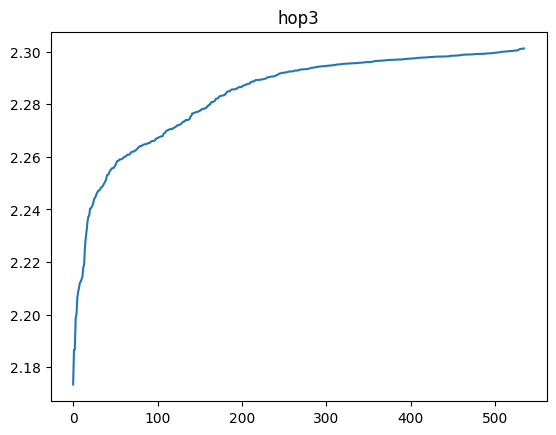

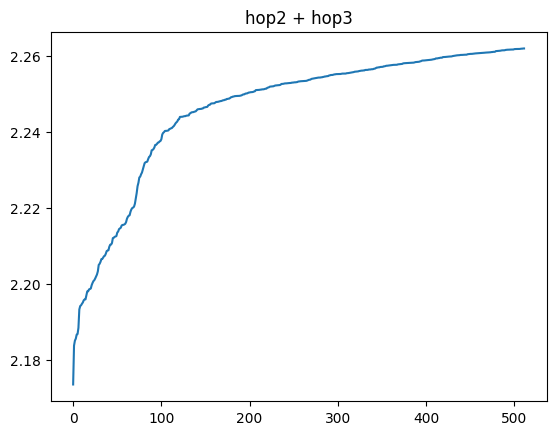

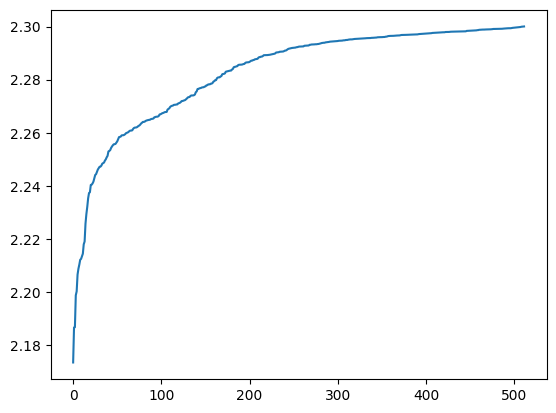

In [30]:
# DFT

DFThop3dir = '/media/hongyu/SSD/SSDUBUNTU/WUSL/soft-decision-tree/model/DFT_Hop3_535.pkl' 
DFThop3, DFThop3_sort_idx, __, __ = pickle.load(open(DFThop3dir, 'rb'))

DFThop2dir = '/media/hongyu/SSD/SSDUBUNTU/WUSL/soft-decision-tree/model/DFT_Hop2_6350.pkl' 
DFThop2, DFThop2_sort_idx, __, __ = pickle.load(open(DFThop2dir, 'rb'))

plt.plot(sorted(DFThop3))
plt.title("hop3")
plt.show()

DFThop2_3 = np.concatenate([DFThop2, DFThop3], axis = -1)
featselect_hop2_3 = np.argsort(DFThop2_3)
# plt.plot(sorted(DFThop2_3)[:512])
plt.plot(DFThop2_3[featselect_hop2_3[:512]])
plt.title("hop2 + hop3")
plt.show()

plt.plot(np.array(DFThop3)[DFThop3_sort_idx[:512]])
plt.show()


In [34]:
# process feature:
# num_sample = 200000
# feattrainhop3 = feattrain[-1].squeeze()
# feattesthop3 = feattest[-1].squeeze()

feattrainhop3 = feattrain[-1].reshape(feattrain[-1].shape[0],-1)
feattesthop3 = feattest[-1].reshape(feattest[-1].shape[0],-1)

feattrainhop2= feattrain[-2].reshape(feattrain[-2].shape[0],-1)
feattesthop2 = feattest[-2].reshape(feattest[-2].shape[0], -1)

feattraintmp = np.concatenate([feattrainhop2, feattrainhop3], axis = -1)
feattesttmp = np.concatenate([feattesthop2, feattesthop3], axis = -1)

print(feattraintmp.shape)
print(feattesttmp.shape)

featdim = 512
feattraintmp = feattraintmp[:,featselect_hop2_3[:featdim]]
feattesttmp = feattesttmp[:,featselect_hop2_3[:featdim]]

print(feattraintmp.shape)
print(feattesttmp.shape)

(200000, 6885)
(10000, 6885)
(200000, 512)
(10000, 512)


In [35]:
# save features for further load


featname = "./model/feat_train_20K+test_dft=512.pkl"
pickle.dump([feattraintmp,feattesttmp],open(featname ,'wb'))
print("feature saved at ", featname)

feature saved at  ./model/feat_train_20K+test_dft=512.pkl


In [101]:
# save labels
yname = "./model/y_train_20K+test.pkl"
pickle.dump([y_train_200K,y_test],open(yname,'wb'))
print("label saved at ", yname)

label saved at  ./model/y_train_20K+test.pkl


# Load Feature

In [3]:
featname = "./model/feat_train_20K+test_dft=1024.pkl"
feattraintmp,feattesttmp = pickle.load(open(featname ,'rb'))
print("feature loaded at ", featname)

yname = "./model/y_train_20K+test.pkl"
y_train_200K, y_test, = pickle.load(open(yname,'rb'))
print("label loaded at ", yname)

print(feattraintmp.shape, y_train_200K.shape)
print(feattesttmp.shape, y_test.shape)

feature loaded at  ./model/feat_train_20K+test_dft=1024.pkl
label loaded at  ./model/y_train_20K+test.pkl
(200000, 1024) (200000, 1)
(10000, 1024) (10000, 1)


# Dataset

In [4]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, x_train, y_train):
        self.x_train = torch.tensor(x_train, dtype=torch.float32)
        self.y_train = torch.tensor(y_train, dtype=torch.int64)

    def __len__(self):
        return len(self.x_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]
    

# create dataset
dataset_train = MyDataset(feattraintmp, y_train_200K)
dataset_test = MyDataset(feattesttmp, y_test)

In [5]:
torch.cuda.empty_cache()

In [23]:
from model import SoftDecisionTree
%load_ext autoreload
%autoreload 2

# Training settings
parser = argparse.ArgumentParser(description='PyTorch CIFAR10')
parser.add_argument('--modelname', type=str,
                    help='model name for saving')
parser.add_argument('--batch-size', type=int, default=10000, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--input-dim', type=int, default=1024, metavar='N',
                    help='input dimension size(default: 28 * 28)')
parser.add_argument('--output-dim', type=int, default=10, metavar='N',
                    help='output dimension size(default: 10)')
parser.add_argument('--max-depth', type=int, default=6, metavar='N',
                    help='maximum depth of tree(default: 8)')
parser.add_argument('--epochs', type=int, default=200, metavar='N',
                    help='number of epochs to train (default: 40)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--lmbda', type=float, default=0.1, metavar='LR',
                    help='temperature rate (default: 0.1)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=5, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--hidden-size', nargs="+", type=int, default= [512, 256],
                    help='hhidden layer for MLP')
parser.add_argument('--linear', type=bool, default=False, metavar='N',
                    help='using linear or Relu for MLP')
parser.add_argument('--loadcpkt', type=str, default="",
                    help='if using previous weights')

# print(parser)
args = parser.parse_args("")

args.cuda = not args.no_cuda and torch.cuda.is_available()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Training

In [24]:
args.modelname = "LC_solver_cpu"
args.batch_size = 40000
args.input_dim = 1024
args.output_dim = 10
args.epochs = 10
args.lr = 0.1
args.max_depth = 5
args.hidden_size = [512, 256]
args.cuda = False
# args.linear = True
print(args)

train_loader = DataLoader(dataset_train, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=args.batch_size, shuffle=False)

Namespace(modelname='LC_solver_cpu', batch_size=40000, input_dim=1024, output_dim=10, max_depth=5, epochs=10, lr=0.1, lmbda=0.1, momentum=0.8, no_cuda=False, seed=1, log_interval=5, hidden_size=[512, 256], linear=False, loadcpkt='', cuda=False)


In [25]:
model = SoftDecisionTree(args)
if args.cuda:
    model.cuda()

print(model)
for epoch in range(1, args.epochs + 1):
    
    model.train_(train_loader, epoch)
    model.test_(test_loader, epoch)

SoftDecisionTree(
  (module_list): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
     

/home/hongyu/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/media/hongyu/SSD/SSDUBUNTU/WUSL/soft-decision-tree/model.py:120: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(self._net(x))


Train Epoch: 1 [0/200000 (0%)]	Loss: nan, Accuracy: 4104/40000 (10.2600%)

Test set: Accuracy: 1000/10000 (10.0000%)

saving best model at ./result/LC_solver_cpu
Train Epoch: 2 [0/200000 (0%)]	Loss: nan, Accuracy: 4076/40000 (10.1900%)

Test set: Accuracy: 1000/10000 (10.0000%)



KeyboardInterrupt: 